<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/echo_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 2.6MB 13.9MB/s 


In [2]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')
import renn

sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/')
import synthetic.synthetic_data as syn
import synthetic.analysis as syn_an

In [51]:
# Reload modules if changes have been made to them
from importlib import reload

reload(syn)
reload(syn_an)

<module 'synthetic.analysis' from '/content/drive/My Drive/ml_research/fixedpoints_nlp/synthetic/analysis.py'>

In [4]:
# Skips any tests and just runs function definitions
run_tests = False

In [136]:
# Chain matrix eigendecomposition
size = 4
Wres = np.zeros((size, size))
for i in range(size):
  if i == size - 1:
    Wres[i,0] = 1
  else:
    Wres[i,i+1] = 1

# Random similarity
rand_sim = rvs(dim=size)
Wres = np.real(np.matmul(np.matmul(rand_sim, Wres), np.linalg.inv(rand_sim)))

eigvals, eigvecs = np.linalg.eig(Wres)

print(Wres)

for i in range(size):
  print('Eigenval: {} Eigenvec: {}'.format(eigvals[i], eigvecs[:, i]))

[[-0.26926986  0.61368219 -0.74203906 -0.01630782]
 [ 0.386382    0.73040362  0.47064882 -0.30936903]
 [ 0.4755693   0.15502386 -0.06334488  0.86359068]
 [ 0.74299161 -0.25665603 -0.47313334 -0.39778888]]
Eigenval: (-1.0000000000000004+0j) Eigenvec: [ 0.60892408+0.j -0.33991219+0.j  0.33248293+0.j -0.63492225+0.j]
Eigenval: (5.551115123125783e-17+1j) Eigenvec: [-0.20932399+0.4690734j  -0.06688283-0.12159186j  0.6489434 +0.j
  0.17487885+0.51496171j]
Eigenval: (5.551115123125783e-17-1j) Eigenvec: [-0.20932399-0.4690734j  -0.06688283+0.12159186j  0.6489434 -0.j
  0.17487885-0.51496171j]
Eigenval: (0.9999999999999999+0j) Eigenvec: [-0.31861996+0.j -0.91975209+0.j -0.21725565+0.j  0.07305743+0.j]


### Echo State Tests

In [133]:
def build_simple_wres(raw_eigvals, rnn_specs, threshold=0.1):
  print('Simplifying Wres.')
  
  eigsvals = raw_eigvals[np.abs(raw_eigvals)>threshold]
  eigsvals = eigsvals[np.imag(eigsvals)>=0]
  # print('Nonzero eigenvalues:', eigsvals)
  Wres = np.zeros((rnn_specs['hidden_size'], rnn_specs['hidden_size']))

  idx = 0
  for eigval in eigsvals: 
    if np.imag(eigval) == 0: # Real eigenvalue
      Wres[idx,idx] = np.real(eigval)
      idx += 1
    else: # Complex eigenvalue
      theta = np.arctan2(np.imag(eigval), np.real(eigval))
      mag = np.abs(eigval)
      Wres[idx,idx] = mag * np.cos(theta)
      Wres[idx,idx+1] = -mag * np.sin(theta)
      Wres[idx+1,idx] = mag * np.sin(theta)
      Wres[idx+1,idx+1] = mag * np.cos(theta)
      idx += 2

  return Wres

def plot_evals(matrix, limits=None):
  eigvals, eigvecs = np.linalg.eig(matrix)
  fig, axe = plt.subplots(1, 1, figsize=(4,4))
  plt.plot(np.real(eigvals), np.imag(eigvals), 'o', ms=10, alpha=0.5, c='b')
  axe.grid()
  if limits != None:
    axe.set_xlim(-limits, limits)
    axe.set_ylim(-limits, limits)
  # Makes unit circle
  x = np.linspace(-1, 1, 1000)
  axe.plot(x, np.sqrt(1-x**2), 'k')
  axe.plot(x, -np.sqrt(1-x**2), 'k')

  axe.set_xlabel('real')
  axe.set_ylabel('imag')

  plt.show()

import numpy as np    

# Found here: https://stackoverflow.com/questions/38426349/how-to-create-random-orthonormal-matrix-in-python-numpy
def rvs(dim=3):
  H = np.eye(dim)
  D = np.ones((dim,))
  for n in range(1, dim):
    x = np.random.normal(size=(dim-n+1,))
    D[n-1] = np.sign(x[0])
    x[0] -= D[n-1]*np.sqrt((x*x).sum())
    # Householder transformation
    Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
    mat = np.eye(dim)
    mat[n-1:, n-1:] = Hx
    H = np.dot(H, mat)
    # Fix the last sign such that the determinant is 1
  D[-1] = (-1)**(1-(dim % 2))*D.prod()
  # Equivalent to np.dot(np.diag(D), H) but faster, apparently
  H = (D*H.T).T
  return H

def initialize_for_ROonly(rnn_specs):

  init_vals = {}

  def initialize_Wres():
    # Wres = 1.0 * np.identity(rnn_specs['hidden_size'])
    # Wres[0,1] = 1
    # Wres[1,2] = 1
    # Wres[2,3] = 1
    # Wres[3,0] = 1
    # Wres[0,0] = 0
    # Wres[1,1] = 0
    # Wres[2,2] = 0
    # Wres[3,3] = 0

    # Wres[4,5] = 1
    # Wres[5,6] = 1
    # Wres[6,4] = 1
    # Wres[4,4] = 0
    # Wres[5,5] = 0
    # Wres[6,6] = 0

    # Wres[7,8] = 1
    # Wres[8,7] = 1
    # Wres[7,7] = 0
    # Wres[8,8] = 0

    Wres = np.zeros((rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # Wres[0,0] = 1.2
    # Wres[1,1] = 1
    # Wres[2,2] = 1
    # Wres[3,3] = 1
    
    # Identity/Zero + Random Gaussian/Uniform
    # div_idx = 108
    # Wres_sub = np.random.normal(size=(rnn_specs['hidden_size']-div_idx, rnn_specs['hidden_size']-div_idx))
    # # Wres_sub = np.random.uniform(low=-1.0, high=1.0, size=(rnn_specs['hidden_size']-div_idx, rnn_specs['hidden_size']-div_idx))
    # eigvals = np.linalg.eigvals(Wres_sub)
    # max_eval = np.max(np.abs(eigvals))
    # Wres_sub = 0.2 * Wres_sub / max_eval
    # Wres = np.identity(rnn_specs['hidden_size'])
    # # Wres = np.zeros((rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # Wres[div_idx:,div_idx:] = Wres_sub

    theta = np.pi/180 * 45
    Wres[0,0], Wres[0,1], Wres[1,0], Wres[1,1] = np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)
    Wres = 1.0 * Wres
    Wres[2,2] = 1.2
    # for i in list([i*2 for i in range(2)]):
    #   theta = np.pi/180 * 45
    #   Wres[i,i], Wres[i,i+1], Wres[i+1,i], Wres[i+1,i+1] = np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)
    # Wres = 1.0 * Wres
    # for i in range(4, 6):
    #   Wres[i,i] = 1.2

    # Random Gaussian/Uniform
    # Wres = np.random.normal(size=(rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # # Wres = np.random.uniform(low=-1.0, high=1.0, size=(rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # eigvals = np.linalg.eigvals(Wres)
    # max_eval = np.max(np.abs(eigvals))
    # print('Max eval:', max_eval)
    # Wres = 1.2 * Wres / max_eval
    # print('Max eval post norm:', np.max(np.abs(np.linalg.eigvals(Wres))))

    # # Creates a filter based on eigenmodes
    # eigvals, eigvecs = np.linalg.eig(Wres)
    # # Sorts by eigenvalue magnitude
    # idx = np.abs(eigvals).argsort()[::-1]   
    # eigvals = eigvals[idx]
    # eigvecs = eigvecs[:,idx]
    # left_eigenvecs = np.linalg.inv(eigvecs)
    # # Filters
    # # eigvals = np.asarray([0 if np.abs(eigvals[i]) > 0.5 else eigvals[i] for i in range(rnn_specs['hidden_size'])])
    # # eigvals = np.asarray([eigvals[i] if np.abs(np.arctan2(np.imag(eigvals[i]), np.real(eigvals[i]))) > np.pi/3 else 0 for i in range(rnn_specs['hidden_size'])])
    # # eigvals = np.asarray([eigvals[i] if np.abs(np.arctan2(np.imag(eigvals[i]), np.real(eigvals[i]))) < 5*np.pi/8 else 0 for i in range(rnn_specs['hidden_size'])])
    # Wres = np.real(np.copy(np.matmul(np.matmul(eigvecs, np.diag(eigvals)), left_eigenvecs)))

    # Random SYMMETRIC Gaussian/Uniform
    # Wres = np.random.normal(size=(rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # # Wres = np.random.uniform(low=-1.0, high=1.0, size=(rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # Wres = 1/2*(Wres + Wres.T)
    # eigvals = np.linalg.eigvals(Wres)
    # max_eval = np.max(np.abs(eigvals))
    # print('Max eval:', max_eval)
    # Wres = 1.2 * Wres / max_eval
    # print('Max eval post norm:', np.max(np.abs(np.linalg.eigvals(Wres))))

    # Random positive only eigenvalues
    # Wres_diag = np.random.uniform(low=0, high=1.0, size=(rnn_specs['hidden_size'],))
    # Wres = np.diag(Wres_diag)
    # eigvals = np.linalg.eigvals(Wres)
    # max_eval = np.max(np.abs(eigvals))
    # print('Max eval:', max_eval)
    # Wres = 1.2 * Wres / max_eval
    # print('Max eval post norm:', np.max(np.abs(np.linalg.eigvals(Wres))))

    # theta = np.pi/180 * 60
    # Wres[0,0], Wres[0,1], Wres[1,0], Wres[1,1] = np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)

    # Permutaiton matrices
    # Wres = np.zeros((rnn_specs['hidden_size'], rnn_specs['hidden_size']))
    # for i in range(rnn_specs['hidden_size']):
    #   if i == rnn_specs['hidden_size'] - 1:
    #     Wres[i, 0] = 1
    #   else:
    #     Wres[i, i+1] = 1

    return jnp.asarray(Wres)

  def initialize_b():
    b = np.zeros((rnn_specs['hidden_size']))
    return jnp.asarray(b)

  def initialize_init_state():
    b = np.zeros((rnn_specs['hidden_size']))
    return jnp.asarray(b)

  def initialize_Winp():
    Winp = np.random.normal(size=(rnn_specs['hidden_size'], rnn_specs['input_size']))
    norm = np.linalg.norm(Winp) # Normalizes Winp by its l2 norm
    return jnp.asarray(1/norm*Winp) #

  init_vals['Wres'] = initialize_Wres()
  init_vals['b'] = initialize_b()
  init_vals['Winp'] = initialize_Winp()
  init_vals['initial_state'] = initialize_init_state()

  # Build simple transformations
  # eigvals, eigvecs = np.linalg.eig(init_vals['Wres'])
  # Wres_new = build_simple_wres(eigvals, rnn_specs, threshold=0.0)
  # eigvals_d, eigvecs_d = np.linalg.eig(Wres_new)
  # sim = np.matmul(eigvecs_d, np.linalg.inv(eigvecs)) # similarlity transformation

  # init_vals['sim'] = sim
  # init_vals['Wres'] = Wres_new
  # init_vals['Winp'] = np.real(np.matmul(sim, init_vals['Winp']))
  # init_vals['initial_state'] = np.real(np.matmul(sim, init_vals['initial_state']))

  # Multiplies by random similarity transformation
  # rand_sim = rvs(dim=128)
  # init_vals['Wres'] = np.real(np.matmul(np.matmul(rand_sim, init_vals['Wres']), np.linalg.inv(rand_sim)))

  # Multiplies by SMALL random similarity transformation
  sub_rand_sim = 3
  rand_sim = np.identity(128)
  rand_sim_sub = rvs(dim=128)
  rand_sim[:sub_rand_sim, :sub_rand_sim] = rand_sim_sub[:sub_rand_sim, :sub_rand_sim]
  init_vals['Wres'] = np.real(np.matmul(np.matmul(rand_sim, init_vals['Wres']), np.linalg.inv(rand_sim)))

  return init_vals

rnn_specs = {
  'input_size': 4,                # Number of inputs to the RNN
  'hidden_size': 128,             # Number of units in the RNN
}

init_vals= initialize_for_ROonly(rnn_specs)

print(init_vals['Wres'][:6,:6])

[[ 1.26605976e+00  1.50756102e+00 -1.53639157e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.51715852e-01  1.34855853e+00 -1.58828536e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.72699422e-01  1.19264201e+00 -4.04703930e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


[2.        +0.j         1.06066012+1.06066012j 1.06066012-1.06066012j]
[[ 0.06917746  0.01456138 -0.0278889   0.00085184]
 [ 0.00344577  0.00648959  0.00432251 -0.01049431]
 [-0.03190184 -0.00106547  0.02431673 -0.01866363]
 [ 0.01167572 -0.00799498 -0.02300789  0.0300233 ]]
[[ 0.04796828 -0.00466811 -0.02420878  0.01434428]
 [ 0.01756312  0.0064574   0.00070031 -0.01167235]
 [-0.01618289  0.01147625  0.02940647 -0.03843688]
 [-0.0073035  -0.01667101 -0.02974835  0.0515737 ]]


Text(0, 0.5, 'count')

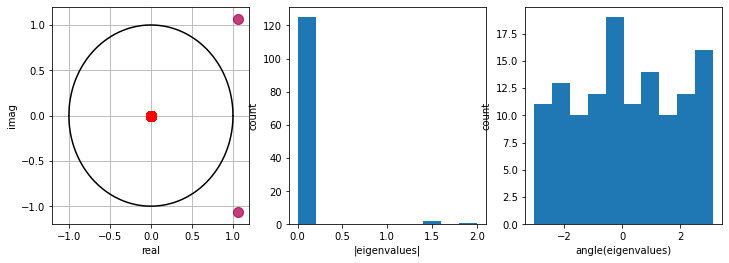

In [122]:
A = np.asarray([[0,1,0,0,0,0], [0,0,1,0,0,0], [0,0,0,1,0,0], [1,0,0,0,0,0], [0,0,0,0,0,1], [0,0,0,0,1,0]])
B = np.asarray([[2,-1,0,-1], [-1,2,-1,0], [0,-1,2,-1], [-1,0,-1,2]])
eigvals, eigvecs = np.linalg.eig(init_vals['Wres'])
# print('Eigenvalues:', eigvals)
print(eigvals[np.abs(eigvals)>0.5])
# Wres_new = build_simple_wres(eigvals, rnn_specs, threshold=0.0)
rand_sim = rvs(dim=128)
Wres_new = np.matmul(np.matmul(rand_sim, init_vals['Wres']), np.linalg.inv(rand_sim))
eigvals_d, eigvecs_d = np.linalg.eig(Wres_new)

sim = np.matmul(eigvecs_d, np.linalg.inv(eigvecs))

print(np.real(np.matmul(np.matmul(sim, init_vals['Wres']), np.linalg.inv(sim)))[:4,:4])
print(Wres_new[:4,:4])

# np.real(np.matmul(np.matmul(eigvecs, np.diag(eigvals)),  np.linalg.inv(eigvecs)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(np.real(eigvals), np.imag(eigvals), 'o', ms=10, alpha=0.5, c='b')
ax1.plot(np.real(eigvals_d), np.imag(eigvals_d), 'o', ms=10, alpha=0.5, c='r')
ax1.grid()
ax1.set_xlim(-1.2, 1.2)
ax1.set_ylim(-1.2, 1.2)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
ax1.plot(x, np.sqrt(1-x**2), 'k')
ax1.plot(x, -np.sqrt(1-x**2), 'k')

ax1.set_xlabel('real')
ax1.set_ylabel('imag')

ax2.hist(np.abs(eigvals), bins=10)
ax2.set_xlabel('|eigenvalues|')
ax2.set_ylabel('count')

ax3.hist(np.angle(eigvals), bins=10)
ax3.set_xlabel('angle(eigenvalues)')
ax3.set_ylabel('count')

### Build Network

In [10]:
from synthetic import synthetic_data as syn

def build_rnn(rnn_specs, train_params):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']
  num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  # Build the RNN cell.
  if rnn_specs['cell_type'] == 'Linear':
    cell = renn.rnn.cells.VanillaRNNIdentity(num_units)
  elif rnn_specs['cell_type'] == 'VanillaReLU':
    cell = renn.rnn.cells.VanillaRNNReLU(num_units)
  elif rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.rnn.cells.VanillaRNN(num_units)
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.rnn.cells.GRU(num_units)
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.rnn.cells.LSTM(num_units)
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.rnn.cells.UGRNN(num_units)
  if rnn_specs['ro_bias']:
    readout_init, readout_apply = stax.Dense(num_outputs)
  else:
    readout_init, readout_apply = Dense_nobias(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1 = jax.random.split(prng_key, 2)
    output_shape, rnn_params = cell.init(k0, input_shape[1:])
    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)

    if rnn_specs['res_type'] in ['RO_only', 'RO_and_Winp', 'Init']:
      # Sets rnn_params to particular init values
      # readout_params= np.real(np.matmul(readout_params.T, np.linalg.inv(rnn_specs['rnn_params_init']['sim']))).T
      rnn_params['initial_state'] = rnn_specs['rnn_params_init']['initial_state'] # input weights
      rnn_params['weights'].A = rnn_specs['rnn_params_init']['Winp'] # input weights
      rnn_params['weights'].W = rnn_specs['rnn_params_init']['Wres'] # recurrent weights
      rnn_params['weights'].b = rnn_specs['rnn_params_init']['b'] # bias
     
    return batch_output_shape, (rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, :, jnp.newaxis]
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    xe_loss = -1 * jnp.mean(logliklihood)

    return xe_loss

  def binary_xent(logits, labels):
    return jnp.mean(-labels * logits - jax.nn.log_sigmoid(-logits))

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    if train_params['reg_type'] == 'l2':
      reg_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    elif train_params['reg_type'] == 'l1':
      reg_loss = train_params['l2reg'] * np.linalg.norm(flatten(params), ord=1)
    
    if rnn_specs['loss_type'] == 'XE':
      xe_loss = xe_loss_fn(logits, labels)
    elif rnn_specs['loss_type'] == 'XE_binary':
      print('Using binary XE loss')
      xe_loss = binary_xent(logits, labels)

    loss = reg_loss + xe_loss

    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return labels_max == predictions

  @jax.jit
  def accuracy_fun_outer(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    return ((logits >= 0.).astype(jnp.int32) == labels).astype(jnp.float32)
  
  if rnn_specs['loss_type'] == 'XE':
    return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun
  elif rnn_specs['loss_type'] == 'XE_binary':
    return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun_outer


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)
    
    if rnn_specs['res_type'] == 'RO_only':  # Sets recurrent gradients to zero
      rnn_grads, ro_grads = gradients
      rnn_grads = optimizers.clip_grads(rnn_grads, 0.0)
      gradients = rnn_grads, ro_grads
    elif rnn_specs['res_type'] == 'RO_and_Winp': # Sets Wres gradients to zero
      rnn_grads, ro_grads = gradients
      rnn_grads['weights'].W = optimizers.clip_grads(rnn_grads['weights'].W, 0.0)
      rnn_grads['weights'].b = optimizers.clip_grads(rnn_grads['weights'].b, 0.0)
      rnn_grads['initial_state'] = optimizers.clip_grads(rnn_grads['initial_state'], 0.0)
      gradients = rnn_grads, ro_grads
    # elif rnn_specs['res_type'] == 'Init': # Sets bias to zero only
    #   rnn_grads, ro_grads = gradients
    #   rnn_grads['weights'].b = optimizers.clip_grads(rnn_grads['weights'].b, 0.0)
    #   gradients = rnn_grads, ro_grads

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun


# More synthetic data functions

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]
  syn_data['index'] = syn_data['index'][shuf_idxs]

  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch, accuracy_fun):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

def train_on_synthetic_data(opt_state, step_fun, get_params, train_params, toy_params, rnn_specs, accuracy_fun):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']
  auto_balance = train_params['auto_balance']

  for dataset in range(train_params['n_datasets']):
    # Generates new train/test datasets 
    syn_data = syn.generate_data(train_set_size, toy_params, rnn_specs['output_size'], auto_balance=auto_balance)
    syn_data_test = syn.generate_data(test_set_size, toy_params, rnn_specs['output_size'], auto_balance=auto_balance)

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch or if auto_balanced (since data will be biased towards rarer classes at end)
      if epoch > 0 or auto_balance:
        print('Shuffling Data')
        syn_data = shuffle_data(syn_data)

      print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
          'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
          'index': syn_data['index'][batch*batch_size:(batch+1)*batch_size, :], # Target mask: list of integers up to phrase_len
        }
        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        # # Check value of the RO vectors
        # rnn_params, readout_params = get_params(opt_state)
        # wO = readout_params.T
        # print(wO[:2,:2])

        if (global_step+1) % print_every == 0:
          test_acc = test_accuracy(get_params(opt_state), syn_data_test, accuracy_fun)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""
  if 'variable_length' not in toy_params: toy_params['variable_length'] = False
  if 'min_phrase_len' not in toy_params: toy_params['min_phrase_len'] = 10
  if 'extreme_test' not in toy_params: toy_params['extreme_test'] = False
  if 'base_word_vals' not in toy_params: toy_params['base_word_vals'] = baseWordValues(toy_params)
  if  'corr_val' not in  toy_params: toy_params['corr_val'] = 0.0
  if  'corr_vals' not in  toy_params: toy_params['corr_vals'] = {}
  if  'the_padding' not in  toy_params: toy_params['the_padding'] = False
  if  'outer_prod' not in  toy_params: toy_params['outer_prod'] = False

  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'

  return train_params, toy_params, rnn_specs

def eval_test_acc(cell, batch, rnn_params):
  """Evalautes test accuracy for a given cell"""
  states =  syn_an._get_all_states_wrapper(batch['inputs'], cell, rnn_params)
  test_acc = np.mean([np.argmax(np.matmul(readout, h[idx[0]])) == np.argmax(lbl[idx[0]]) for h, idx, lbl 
                     in zip(states, batch['index'], batch['labels'])])
  return test_acc

# Training

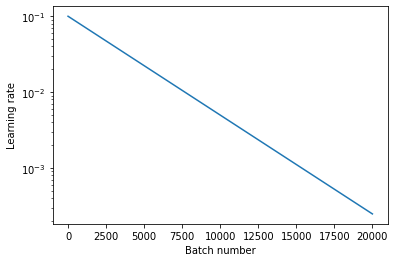

In [9]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

Total words: 4 Words: ['bad', 'good', 'the', 'not']
Total sentiments: 2 Sentiments: ['Bad', 'Good']


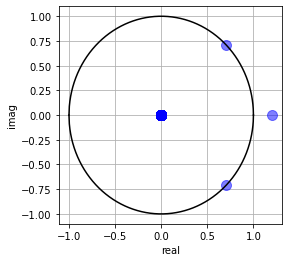

Initial Wres [[ 1.06940766 -0.0644501  -0.24193036  0.        ]
 [ 1.05311895  0.71165378  0.69366933  0.        ]
 [ 0.19378573 -0.48633668  0.83315215  0.        ]
 [ 0.          0.          0.          0.        ]]
Initial init_state [0. 0. 0. 0.]
Sythentic data generated in: 19.46 sec. Autobalanced: False. Uniform score: False
Sythentic data generated in: 0.05 sec. Autobalanced: False. Uniform score: False
Running batches 0 to 1000
Step 100 in 2.80 sec, step size: 0.09707, test acc 0.0000, avg training loss nan
Step 200 in 1.18 sec, step size: 0.09420, test acc 0.0000, avg training loss nan
Step 300 in 1.14 sec, step size: 0.09142, test acc 0.0000, avg training loss nan
Step 400 in 1.20 sec, step size: 0.08872, test acc 0.0000, avg training loss nan
Step 500 in 1.18 sec, step size: 0.08610, test acc 0.0000, avg training loss nan
Step 600 in 1.13 sec, step size: 0.08355, test acc 0.0000, avg training loss nan
Step 700 in 1.19 sec, step size: 0.08108, test acc 0.0000, avg training lo

KeyboardInterrupt: ignored

In [134]:
seed = 342444
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 25,
  'loss_type': 'XE',
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'context_words' : True,
  'unordered_class': False, # Use an unordered class set (also used for outer)
  'n_unordered': 3,
  'words': ['bad', 'good', 'the', 'not'], #['kinda0', 'kinda1', 'kinda2', 'the', 'not'], #['awesome', 'good', 'bad', 'awful', 'okay', 'the'],
  'uniform_score': False, # Uniform distribution over scores
  'outer_prod': False,
  'filter_classes': False,
  # 'corr_vals': {'01': 0.7, '12': 0.7, '23': 0.7, '30': 0.7,}
  # 'score_vals': [np.asarray([2, -1]), np.asarray([1, 1/2]),  np.asarray([-1, 1/2]), np.asarray([-2, -1]), np.asarray([0, 2])],
  'five_order_match': False,
}

# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
toy_params['sentiments'] = ['Bad', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

toy_params['base_word_vals'] = syn.baseWordValues(toy_params)

########## RNN hyperparameters ##########
rnn_specs = {
  'res_type': 'RO_and_Winp',                        # Supports 'RO_only', 'RO_and_Winp', 'Init'
  'cell_type': 'VanillaReLU',                       # Supports 'Linear', 'Vanilla', 'VanillaReLU', 'GRU', 'LSTM', or 'UGRNN'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
  'loss_type': 'XE_binary' if toy_params['outer_prod']   else 'XE'
}

rnn_specs['rnn_params_init'] = initialize_for_ROonly(rnn_specs) # Set initial value of rnn weights

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'reg_type': 'l2',        # type of regularization
  'l2reg': 1e-10,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets':  6,                           # Number of new train sets to generate total (this is slow)
  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 300,
  'auto_balance': False,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_2outer_match2_noRO_l2is5e-4.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs, train_params)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  rnn_params, readout_params = initial_params

  plot_evals(rnn_params['weights'].W, limits=None) # Plots the eigenvalues of Wres

  print('Initial Wres', rnn_params['weights'].W[:4,:4])
  print('Initial init_state', rnn_params['initial_state'][:4])
  # print('Initial Winp', rnn_params['weights'].A[:4,:4])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:
  train_params['train_losses'] = []
  train_params['total_steps'] = 24000
  train_params['global_step'] = train_params['total_steps']

# Generate synthetic data and run training on said data
opt_state, train_params = train_on_synthetic_data(opt_state, step_fun, get_params, train_params, toy_params, rnn_specs, accuracy_fun)

if 'score_to_idx_map' in toy_params: toy_params.pop('score_to_idx_map') # This is too big to save
train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

print('Final Wres', rnn_params['weights'].W[:4,:4])
print('Final init_state', rnn_params['initial_state'][:4])
# print('Final Winp', rnn_params['weights'].A[:4,:4])

In [120]:
# Builds cell and returns test accuracy
cell = syn_an.build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 1000

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

syn_data_test = syn.generate_data(n_trials, toy_params, rnn_specs['output_size'], auto_balance=True)
print('Full test acc:', eval_test_acc(cell, syn_data_test, rnn_params))

Using VanillaReLU cell
Looking for num per class: [500. 500.]
Sythentic data generated in: 0.22 sec. Autobalanced: True. Uniform score: False
Full test acc: 0.979


Text(0, 0.5, 'Train Loss')

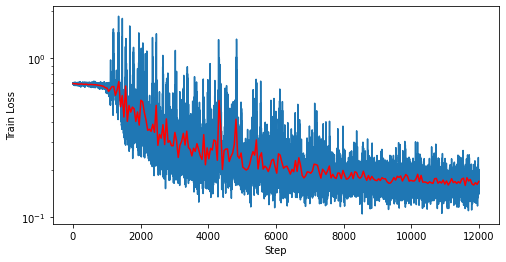

In [12]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [55]:
# Uses cell/hidden states generated above

hs = syn_an.rnn_states(cell, syn_data_test, rnn_params, only_final=False)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

print('Readout shape:', readout.shape)

(12000, 128)
Readout shape: (2, 128)


Top 5 components: 0.9412334 ( [0.35339522 0.26271057 0.17915857 0.07856426 0.06740476] )
Participation Ratio: 4.203620219943501
Copy this: PCA: [0.35339522 0.26271057 0.17915857 0.07856426 0.06740476] PR: 4.203620219943501
Category 0 states: 500
Category 1 states: 500
Readout vec proj via PCA: [[-0.5830857  -0.33765668]
 [ 1.586597    1.6535075 ]
 [-0.00906886 -0.8018568 ]
 [-0.3353575  -0.6811336 ]
 [ 0.79163516  0.85140043]]


(128,)

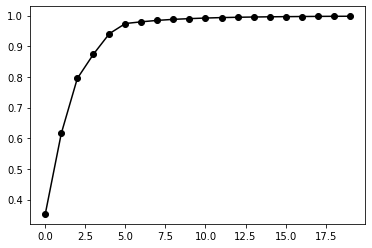

In [56]:
pc_dims = 5

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', syn_an.participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape

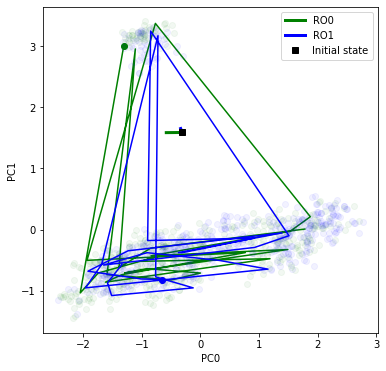

In [57]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for i in range(len(toy_params['sentiments'])):
  if len(states[i]) > 0:
    pca_states = pca.transform(np.vstack(states[i])).T
    # plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.05, 
    #          linestyle=None, label=state_labels[i])
    for j in range(len(states[i])): # Plot final hidden states
      pca_seq = pca.transform(states[i][j]).T
      plt.plot(pca_seq[pc1, toy_params['phrase_length']-2], pca_seq[pc2, toy_params['phrase_length']-2], 
             c = state_colors[i], marker='o', alpha=0.05)
    
    pca_path = pca.transform(states[i][0]).T
    plt.plot(pca_path[pc1], pca_path[pc2], c = state_colors[i], marker=None, alpha=1.0)
    plt.plot(pca_path[pc1, toy_params['phrase_length']-2], pca_path[pc2, toy_params['phrase_length']-2], 
             c = state_colors[i], marker='o', alpha=1.0)

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

# path_idxs = [52, 454, 252]
# for path_idx in path_idxs:
#   path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
#   plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(syn_data_test['labels'][path_idx][27])], marker='.', label='Random Path')
#   print('Path label:', syn_data_test['labels'][path_idx][27])

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
plot_coords = None
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

plt.legend()

x 1.0000001
y 1.0
x.y 1.206994e-06


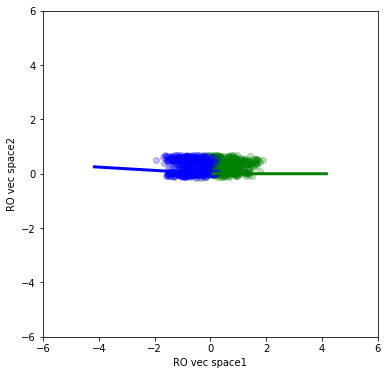

In [16]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for i in range(len(toy_params['sentiments'])):
  # x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  # y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  # plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.01, label=state_labels[i])
  for j in range(len(states[i])): # Plot final hidden states
    x_vals = np.dot(np.matmul(np.vstack(states[i][j]), proj), x_basis)
    y_vals = np.dot(np.matmul(np.vstack(states[i][j]), proj), y_basis)    
    plt.plot(x_vals[toy_params['phrase_length']-2], y_vals[toy_params['phrase_length']-2], state_colors[i]+'o', alpha=0.25)
  # pca_path_x =  np.dot(np.matmul(states[i][0], proj), x_basis)
  # pca_path_y =  np.dot(np.matmul(states[i][0], proj), y_basis)
  # plt.plot(pca_path_x, pca_path_y, c = state_colors[i], marker=None, alpha=1.0)
  # plt.plot(pca_path_x[toy_params['phrase_length']-2], pca_path_y[toy_params['phrase_length']-2], 
  #           c = state_colors[i], marker='o', alpha=1.0)

for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], state_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plot_coords = 6
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

#### Readout Vector Analysis

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

# Percentage of readout vector mag in PCA dimensions
if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

print('Readout shape:', readout.shape)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

print('Theoretical angle:', 180/np.pi * np.arccos(-1/(toy_params['n_unordered']-1)))

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)
# indices = [i for i in range(len(readout))]
# for i in range(len(readout)):
#   A = []
#   for j in range(len(readout)):
#     if i != j:
#       A.append(readout[j])
#   print('Perc of {} in rest:'.format(i), subspace_perc(np.asarray(A).T, readout[i]))

Readout shape: (2, 128)
Readout 0 mag: 3.3975139
Readout 0 (perc in first 2 PC dims): 0.9610282
Readout 1 mag: 3.3515086
Readout 1 (perc in first 2 PC dims): 0.9610822
Theoretical angle: 120.00000000000001
Angle (1, 0): 173.93669581857426
Avg perc in rest for subspace dim 1: 0.9944058060646057


### Deflection Tests

Winp shape (128, 4)
Wrec shape (128, 128)
Word tensor [1. 0. 0. 0.]
Word tensor [0. 1. 0. 0.]
Word tensor [0. 0. 1. 0.]
Word tensor [0. 0. 0. 1.]


Text(0, 0.5, 'PC1')

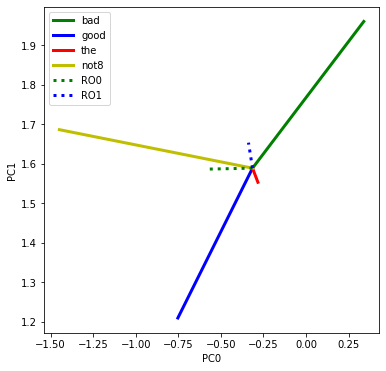

In [58]:
Winp = rnn_params['weights'].A
Wres = rnn_params['weights'].W
print('Winp shape', Winp.shape)
print('Wrec shape', Wres.shape)

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T

for word_idx in range(len(toy_params['words'])):
  word_tensor = syn.wordToTensor(toy_params['words'][word_idx], toy_params['words'])[0]
  print('Word tensor', word_tensor)
  word_embed = np.matmul(Wres, np.matmul(Winp, word_tensor))
  # word_embed = np.matmul(Winp, word_tensor)

  word_embed_pca = pca.transform(np.atleast_2d(word_embed)).T
  plt.plot([pca_zero[pc1], word_embed_pca[pc1]], [pca_zero[pc2], word_embed_pca[pc2]], 
           state_colors[word_idx], linewidth = 3, label=toy_params['words'][word_idx])
  # for i in range(len(readout)):
  #   print('Dot with readout {}: {}'.format(i, np.dot(readout[i], word_embed)/(np.linalg.norm(readout[i])*np.linalg.norm(word_embed))))

# Plots readout direction
pca_ro = pca.transform(readout)
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(i), linestyle='dotted')

plt.legend()

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))


x 1.0000001
y 1.0
x.y 1.206994e-06
Word tensor [1. 0. 0. 0.]
Word tensor [0. 1. 0. 0.]
Word tensor [0. 0. 1. 0.]
Word tensor [0. 0. 0. 1.]


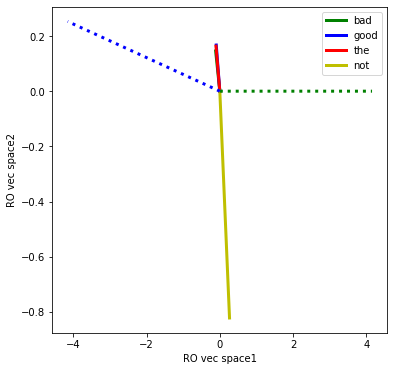

In [18]:
# Project deflections onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for word_idx in range(len(toy_params['words'])):
  word_tensor = syn.wordToTensor(toy_params['words'][word_idx], toy_params['words'])[0]
  print('Word tensor', word_tensor)
  word_embed = np.matmul(Wres, np.matmul(Winp, word_tensor))

  embed_x =  np.dot(np.matmul(word_embed, proj), x_basis)
  embed_y =  np.dot(np.matmul(word_embed, proj), y_basis)

  plt.plot([0, embed_x], [0, embed_y], 
           state_colors[word_idx], linewidth = 3, label=toy_params['words'][word_idx])

for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], state_colors[i], 
           linewidth = 3, linestyle='dotted')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')
plt.legend()

plot_coords = None
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

Word: bad Word tensor [1. 0. 0. 0.]
Max indices: [58 57 82]
Max index eigenvalue: 2.3711897e-09
Word: good Word tensor [0. 1. 0. 0.]
Max indices: [115 114 107]
Max index eigenvalue: 5.446863e-10
Word: the Word tensor [0. 0. 1. 0.]
Max indices: [127 126  33]
Max index eigenvalue: 3.504531e-11
Word: not Word tensor [0. 0. 0. 1.]
Max indices: [127 126  59]
Max index eigenvalue: 3.504531e-11


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


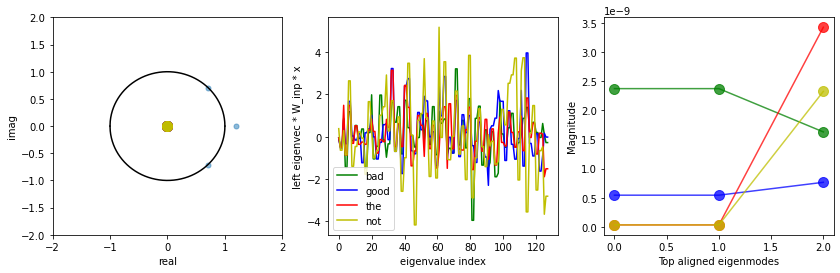

In [19]:
# Deflection alignments with Wres
eigvals, eigvecs = np.linalg.eig(Wres)
# Sorts by eigenvalue magnitude
idx = np.abs(eigvals).argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

word_embed = np.zeros((len(toy_params['words']), rnn_specs['hidden_size']))
for word_idx in range(len(toy_params['words'])):
  word_tensor = syn.wordToTensor(toy_params['words'][word_idx], toy_params['words'])[0]
  word_embed[word_idx] = np.matmul(Winp, word_tensor)

avg_embed = np.mean(word_embed, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
ax1.plot(np.real(eigvals), np.imag(eigvals), '.', ms=10, alpha=0.5)
plt_range = 2
ax1.set_xlim(-plt_range, plt_range)
ax1.set_ylim(-plt_range, plt_range)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
ax1.plot(x, np.sqrt(1-x**2), 'k')
ax1.plot(x, -np.sqrt(1-x**2), 'k')

ax1.set_xlabel('real')
ax1.set_ylabel('imag')
ax2.set_ylabel('left eigenvec * W_inp * x')
ax2.set_xlabel('eigenvalue index')
ax3.set_xlabel('Top aligned eigenmodes')
ax3.set_ylabel('Magnitude')


n_evals = 3
top_evlas = np.zeros((len(toy_params['words']), n_evals), dtype=int)
for word_idx in range(len(toy_params['words'])):
  word_tensor = syn.wordToTensor(toy_params['words'][word_idx], toy_params['words'])[0]
  print('Word:', toy_params['words'][word_idx], 'Word tensor', word_tensor)
  word_embed = np.matmul(Winp, word_tensor)

  left_eigenvecs = np.linalg.inv(eigvecs)

  # Tests alignment with (left, unormalized) eigenvecs
  # eigvec_align = np.matmul((word_embed-avg_embed).T, eigvecs)/np.linalg.norm(word_embed-avg_embed)
  eigvec_align = np.matmul(left_eigenvecs, word_embed)

  ax2.plot(eigvec_align, color=state_colors[word_idx], label=toy_params['words'][word_idx])

  top_evlas[word_idx] = np.flip(np.argsort(np.abs(eigvec_align))[-n_evals:])
  ax1.plot(np.real(eigvals[top_evlas[word_idx]]), np.imag(eigvals[top_evlas[word_idx]]), 'o', color=state_colors[word_idx], ms=10, alpha=0.75)
  ax3.plot(np.abs(eigvals[top_evlas[word_idx]]), 'o-', color=state_colors[word_idx], ms=10, alpha=0.75)

  max_idx = np.argmax(np.abs(eigvec_align))
  print('Max indices:', top_evlas[word_idx])
  print('Max index eigenvalue:', np.abs(eigvals[max_idx]))

ax2.legend()

Max indices: [ 0  1  2 12 13]
Max index eigenvalue: 1.2
Max indices: [ 0  2  1 13 12]
Max index eigenvalue: 1.2


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


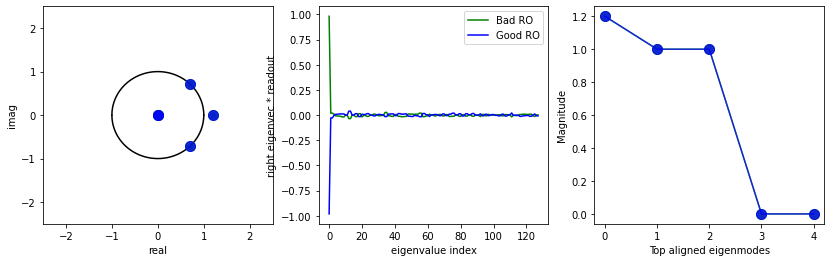

In [20]:
# Readout alignments with Wres
eigvals, eigvecs = np.linalg.eig(Wres)
# Sorts by eigenvalue magnitude
idx = np.abs(eigvals).argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
ax1.plot(np.real(eigvals), np.imag(eigvals), '.', ms=10, alpha=0.5)
plt_range = 2.5
ax1.set_xlim(-plt_range, plt_range)
ax1.set_ylim(-plt_range, plt_range)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
ax1.plot(x, np.sqrt(1-x**2), 'k')
ax1.plot(x, -np.sqrt(1-x**2), 'k')

ax1.set_xlabel('real')
ax1.set_ylabel('imag')
ax2.set_ylabel('right eigenvec * readout')
ax2.set_xlabel('eigenvalue index')
ax3.set_xlabel('Top aligned eigenmodes')
ax3.set_ylabel('Magnitude')

n_evals = 5
top_evlas = np.zeros((readout.shape[0], n_evals), dtype=int)
for ro_idx in range(readout.shape[0]):

  eigvec_align = np.matmul(readout[ro_idx], eigvecs)/np.linalg.norm(readout[ro_idx])

  ax2.plot(eigvec_align, color=state_colors[ro_idx], label=toy_params['sentiments'][ro_idx]+' RO')

  top_evlas[ro_idx] = np.flip(np.argsort(np.abs(eigvec_align))[-n_evals:])
  ax1.plot(np.real(eigvals[top_evlas[ro_idx]]), np.imag(eigvals[top_evlas[ro_idx]]), 'o', color=state_colors[ro_idx], ms=10, alpha=0.75)
  ax3.plot(np.abs(eigvals[top_evlas[ro_idx]]), 'o-', color=state_colors[ro_idx], ms=10, alpha=0.75)

  max_idx = np.argmax(np.abs(eigvec_align))
  print('Max indices:', top_evlas[ro_idx])
  print('Max index eigenvalue:', np.abs(eigvals[max_idx]))

ax2.legend()

Max indices: [ 0  1  2 12 13]
Max index eigenvalue: 1.2
Max indices: [ 0  2  1 13 12]
Max index eigenvalue: 1.2
Word: bad Word tensor [1. 0. 0. 0.]
Word: good Word tensor [0. 1. 0. 0.]
Word: the Word tensor [0. 0. 1. 0.]
Word: not Word tensor [0. 0. 0. 1.]


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/

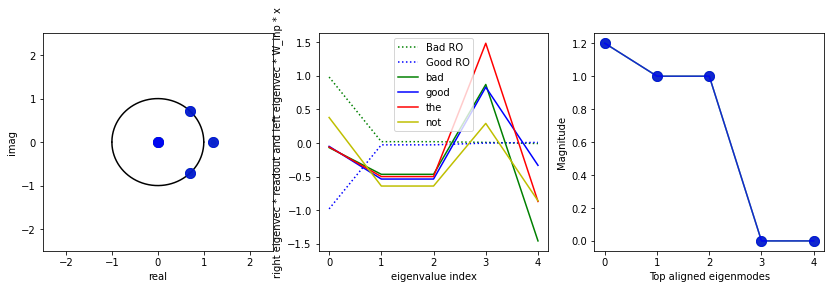

In [21]:
# Plots top word AND readout deflections

# Readout alignments with Wres
eigvals, eigvecs = np.linalg.eig(Wres)
# Sorts by eigenvalue magnitude
idx = np.abs(eigvals).argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

n_eigs = 5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
ax1.plot(np.real(eigvals), np.imag(eigvals), '.', ms=10, alpha=0.5)
plt_range = 2.5
ax1.set_xlim(-plt_range, plt_range)
ax1.set_ylim(-plt_range, plt_range)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
ax1.plot(x, np.sqrt(1-x**2), 'k')
ax1.plot(x, -np.sqrt(1-x**2), 'k')

ax1.set_xlabel('real')
ax1.set_ylabel('imag')
ax2.set_ylabel('right eigenvec * readout and left eigenvec * W_inp * x')
ax2.set_xlabel('eigenvalue index')
ax3.set_xlabel('Top aligned eigenmodes')
ax3.set_ylabel('Magnitude')

n_evals = 5
top_evlas = np.zeros((readout.shape[0], n_evals), dtype=int)
for ro_idx in range(readout.shape[0]):

  eigvec_align = np.matmul(readout[ro_idx], eigvecs)/np.linalg.norm(readout[ro_idx])

  ax2.plot(eigvec_align[:n_eigs], color=state_colors[ro_idx], label=toy_params['sentiments'][ro_idx]+' RO', linestyle='dotted')

  top_evlas[ro_idx] = np.flip(np.argsort(np.abs(eigvec_align))[-n_evals:])
  ax1.plot(np.real(eigvals[top_evlas[ro_idx]]), np.imag(eigvals[top_evlas[ro_idx]]), 'o', color=state_colors[ro_idx], ms=10, alpha=0.75)
  ax3.plot(np.abs(eigvals[top_evlas[ro_idx]]), 'o-', color=state_colors[ro_idx], ms=10, alpha=0.75)

  max_idx = np.argmax(np.abs(eigvec_align))
  print('Max indices:', top_evlas[ro_idx])
  print('Max index eigenvalue:', np.abs(eigvals[max_idx]))

top_evlas = np.zeros((len(toy_params['words']), n_evals), dtype=int)
for word_idx in range(len(toy_params['words'])):
  word_tensor = syn.wordToTensor(toy_params['words'][word_idx], toy_params['words'])[0]
  print('Word:', toy_params['words'][word_idx], 'Word tensor', word_tensor)
  word_embed = np.matmul(Winp, word_tensor)

  left_eigenvecs = np.linalg.inv(eigvecs)

  # Tests alignment with (left, unormalized) eigenvecs
  # eigvec_align = np.matmul((word_embed-avg_embed).T, eigvecs)/np.linalg.norm(word_embed-avg_embed)
  eigvec_align = np.matmul(left_eigenvecs, word_embed)

  ax2.plot(eigvec_align[:n_eigs], color=state_colors[word_idx], label=toy_params['words'][word_idx])

  # top_evlas[word_idx] = np.flip(np.argsort(np.abs(eigvec_align))[-n_evals:])
  # ax1.plot(np.real(eigvals[top_evlas[word_idx]]), np.imag(eigvals[top_evlas[word_idx]]), 'o', color=state_colors[word_idx], ms=10, alpha=0.75)
  # ax3.plot(np.abs(eigvals[top_evlas[word_idx]]), 'o-', color=state_colors[word_idx], ms=10, alpha=0.75)

  # max_idx = np.argmax(np.abs(eigvec_align))
  # print('Max indices:', top_evlas[word_idx])
  # print('Max index eigenvalue:', np.abs(eigvals[max_idx]))

ax2.legend()

### Input Analysis

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'Hidden alignment right eigenvector')

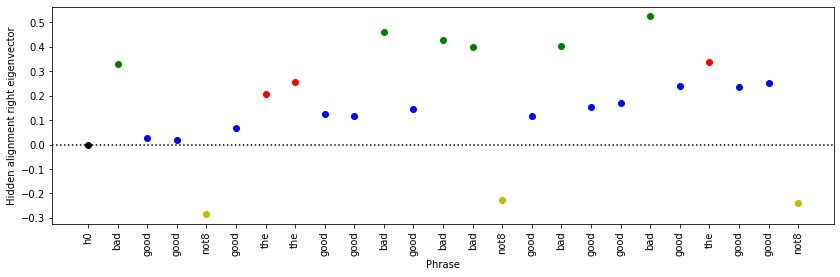

In [60]:
# Shows the hidden state space evolution for a given phrase in terms of the top right eigenvectors
hs_idx = 0
eig_idx = [0, ]
plt.figure(figsize=(14,4))

# print('Phrase:', syn_data_test['inputs'][hs_idx])

state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
phrase_words = ['h0',]

plt.axhline(0.0, color='k', linestyle='dotted')


for seq_idx in range(hs[hs_idx].shape[0]+1):
  hs_val = h0 if seq_idx == 0 else hs[hs_idx][seq_idx-1]
  word_color = 'k'
  if seq_idx > 0:
    word_idx = np.argmax(syn_data_test['inputs'][hs_idx, seq_idx-1]) # Deflection from corresponding word
    phrase_words.append(toy_params['words'][word_idx])
    word_color = state_colors[word_idx]
  eigvec_align = np.matmul(hs_val, eigvecs)

  plt.scatter([seq_idx for _ in range(len(eig_idx))], [eigvec_align[eig_idx]], color=word_color)

plt.xticks(ticks=[i for i in range(0,toy_params['phrase_length'])], labels=phrase_words, rotation=90)
plt.xlabel('Phrase')
plt.ylabel('Hidden alignment right eigenvector')

Text(0, 0.5, 'Hidden alignment Readouts')

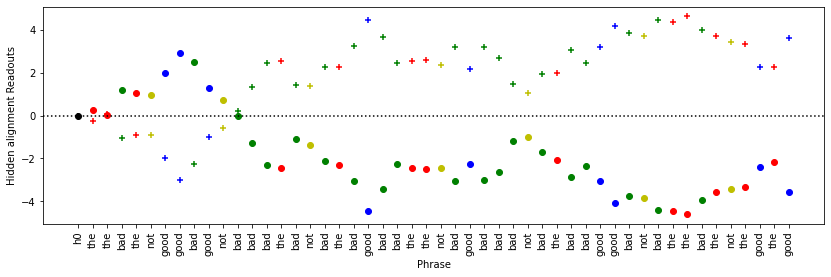

In [35]:
# Shows the hidden state space evolution for a given phrase in terms of the top right eigenvectors
hs_idx = 1
plt.figure(figsize=(14,4))

# print('Phrase:', syn_data_test['inputs'][hs_idx])

state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
phrase_words = ['h0',]

plt.axhline(0.0, color='k', linestyle='dotted')

for seq_idx in range(hs[hs_idx].shape[0]+1):
  hs_val = h0 if seq_idx == 0 else hs[hs_idx][seq_idx-1]
  word_color = 'k'
  if seq_idx > 0:
    word_idx = np.argmax(syn_data_test['inputs'][hs_idx, seq_idx-1]) # Deflection from corresponding word
    phrase_words.append(toy_params['words'][word_idx])
    word_color = state_colors[word_idx]
  ro_align = np.matmul(readout, hs_val)

  plt.scatter([seq_idx], [ro_align[0]], color=word_color, marker='o')
  plt.scatter([seq_idx], [ro_align[1]], color=word_color, marker='+')

plt.xticks(ticks=[i for i in range(0,toy_params['phrase_length'])], labels=phrase_words, rotation=90)
plt.xlabel('Phrase')
plt.ylabel('Hidden alignment Readouts')

### Eigenmode Analysis

In [46]:
# Drops out eigemodes one at a time to see which ones are crucial to performance
import copy

# Readout alignments with Wres
Wres = rnn_params['weights'].W
eigvals, eigvecs = np.linalg.eig(Wres)
# Sorts by eigenvalue magnitude
idx = np.abs(eigvals).argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
left_eigenvecs = np.linalg.inv(eigvecs)

print('Full test acc:', eval_test_acc(cell, syn_data_test, rnn_params))
rnn_params_new = copy.deepcopy(rnn_params)

test_accs = np.zeros((Wres.shape[0],))
for eig_idx in range(Wres.shape[0]):
  eigvals_new = np.copy(eigvals)
  eigvals_new[eig_idx] = 0
  Wres_new = np.real(np.copy(np.matmul(np.matmul(eigvecs, np.diag(eigvals_new)), left_eigenvecs)))
  rnn_params_new['weights'].W = Wres_new
  test_accs[eig_idx] = eval_test_acc(cell, syn_data_test, rnn_params_new)

Full test acc: 0.983


In [47]:
toy_params_nc = copy.deepcopy(toy_params)
toy_params_nc['words'].remove('not')
toy_params_nc['words'].append('<avg>') # special word that is average of other one-hots
syn_data_test_nc = syn.generate_data(n_trials, toy_params_nc, rnn_specs['output_size'], auto_balance=True)

print('Full test acc (no context):', eval_test_acc(cell, syn_data_test_nc, rnn_params))
rnn_params_new = copy.deepcopy(rnn_params)

test_accs_nc = np.zeros((Wres.shape[0],))
for eig_idx in range(Wres.shape[0]):
  eigvals_new = np.copy(eigvals)
  eigvals_new[eig_idx] = 0
  Wres_new = np.real(np.copy(np.matmul(np.matmul(eigvecs, np.diag(eigvals_new)), left_eigenvecs)))
  rnn_params_new['weights'].W = Wres_new
  test_accs_nc[eig_idx] = eval_test_acc(cell, syn_data_test_nc, rnn_params_new)

Looking for num per class: [500. 500.]
Sythentic data generated in: 0.22 sec. Autobalanced: True. Uniform score: False
Full test acc (no context): 0.972


Text(0, 0.5, 'Test Accuracy')

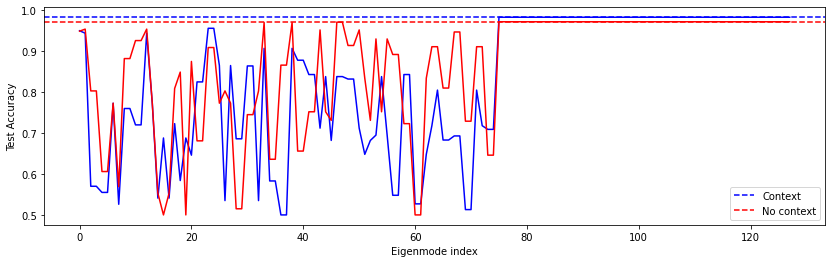

In [48]:

plt.figure(figsize=(14,4))
plt.plot([i for i in range(Wres.shape[0])], test_accs, c='b')
plt.plot([i for i in range(Wres.shape[0])], test_accs_nc, c='r')
plt.axhline(eval_test_acc(cell, syn_data_test, rnn_params), color='b', linestyle='dashed', label='Context')
plt.axhline(eval_test_acc(cell, syn_data_test_nc, rnn_params), color='r', linestyle='dashed', label='No context')
plt.legend()
plt.xlabel('Eigenmode index')
plt.ylabel('Test Accuracy')

### Delta h Analysis

In [ ]:
# Breaks deflections up strictly based off word.

words = toy_params['words']
# points_final_pca = np.zeros((len(words), len(pts), pc_dims))

word_defs = [[] for _ in range(len(words))]
for hs_idx in range(len(hs)):
  if not hs_idx % 200: print('Index:', hs_idx)
  for seq_idx in range(hs[hs_idx].shape[0]):
    word_idx = np.argmax(syn_data_test['inputs'][hs_idx, seq_idx])# If deflection is from corresponding word
    if seq_idx == 0:
      word_defs[word_idx].append(hs[hs_idx][seq_idx] - h0)
    else:
      word_defs[word_idx].append(hs[hs_idx][seq_idx] - hs[hs_idx][seq_idx-1])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [29]:
# Breaks deflections up based off word AND context.

words = toy_params['words']
print('Words:', words)
# points_final_pca = np.zeros((len(words), len(pts), pc_dims))

word_defs = [[] for _ in range(len(words)+3)]
for hs_idx in range(len(hs)):
  if not hs_idx % 50: print('Index:', hs_idx)
  not_count = 0
  for seq_idx in range(hs[hs_idx].shape[0]):
    word_idx = np.argmax(syn_data_test['inputs'][hs_idx, seq_idx]) # If deflection is from corresponding word
    deflection = hs[hs_idx][seq_idx] - h0 if seq_idx == 0 else hs[hs_idx][seq_idx] - hs[hs_idx][seq_idx-1]
    if words[word_idx] == 'not': 
      not_count = 4    # foound a not
      word_defs[2*word_idx].append(deflection)
    elif (word_idx in [0, 1, 2]) and (not_count > 0):
      word_defs[2*word_idx+1].append(deflection)
    else:
      word_defs[2*word_idx].append(deflection)
    
    if not_count > 0: not_count -= 1

Words: ['bad', 'good', 'the', 'not']
Index: 0
Index: 50
Index: 100
Index: 150
Index: 200
Index: 250
Index: 300
Index: 350
Index: 400
Index: 450
Index: 500
Index: 550
Index: 600
Index: 650
Index: 700
Index: 750
Index: 800
Index: 850
Index: 900
Index: 950


Text(0, 0.5, 'PC3')

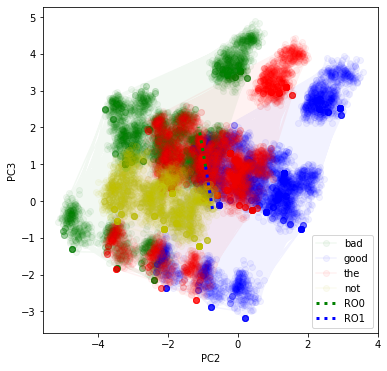

In [ ]:
plt.figure(figsize=(6, 6))

pc1 = 2
pc2 = 3

state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for i in range(len(words)):
  if len(word_defs[i]) > 0:
    pca_words = pca.transform(np.vstack(word_defs[i])).T
    plt.plot(pca_words[pc1], pca_words[pc2], c = state_colors[i], marker='o', alpha=0.05, 
             linestyle=None, label=words[i])
    
# Plots readout direction
pca_ro = pca.transform(readout)
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(i), linestyle='dotted')

plt.legend()

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

x 1.0000001
y 1.0
x.y 1.206994e-06


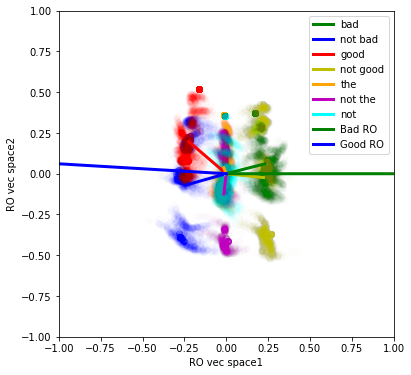

In [31]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

word_labels = ['bad', 'not bad', 'good', 'not good', 'the', 'not the', 'not']

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for i in range(0, 7): # Scatter of all deflections
  x_vals = np.dot(np.matmul(np.vstack(word_defs[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(word_defs[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, c=state_colors[i], alpha=0.01, marker='o',
           linewidth=0.0) #words[i])

for i in range(0, 7):# Scatter of all deflections
  x_vals = np.dot(np.matmul(np.vstack(word_defs[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(word_defs[i]), proj), y_basis)
  plt.plot([0.0, np.mean(x_vals)], [0.0, np.mean(y_vals)], c=state_colors[i], alpha=1.0, marker=None,
           linewidth=3.0 ,label=word_labels[i]) #words[i])

for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], state_colors[i], linewidth = 3, 
           label=toy_params['sentiments'][i]+' RO')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.legend()

plot_coords = 1.0
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/

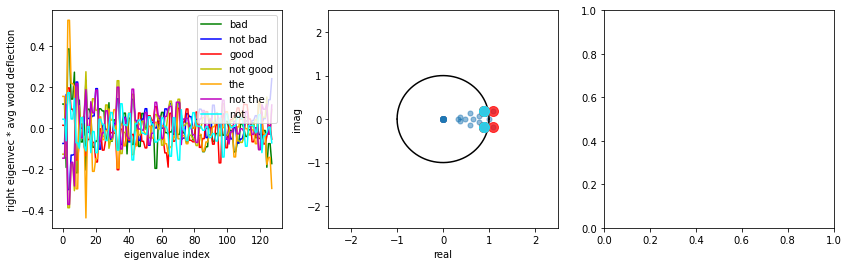

In [68]:
# Deflection alignment with right eigenvectors

eigvals, eigvecs = np.linalg.eig(Wres)
# Sorts by eigenvalue magnitude
idx = np.abs(eigvals).argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

ax2.plot(np.real(eigvals), np.imag(eigvals), '.', ms=10, alpha=0.5)
plt_range = 2.5
ax2.set_xlim(-plt_range, plt_range)
ax2.set_ylim(-plt_range, plt_range)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
ax2.plot(x, np.sqrt(1-x**2), 'k')
ax2.plot(x, -np.sqrt(1-x**2), 'k')

ax2.set_xlabel('real')
ax2.set_ylabel('imag')
ax1.set_ylabel('right eigenvec * avg word deflection')
ax1.set_xlabel('eigenvalue index')

n_evals = 2

state_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
for i in range(0, 7):
  mean_def = np.mean(np.vstack(word_defs[i]), axis=0)
  
  eigvec_align = np.matmul(mean_def, eigvecs)/np.linalg.norm(mean_def)

  ax1.plot(eigvec_align, color=state_colors[i], label=word_labels[i])
  top_evlas = np.flip(np.argsort(np.abs(eigvec_align))[-n_evals:])
  ax2.plot(np.real(eigvals[top_evlas]), np.imag(eigvals[top_evlas]), 'o', color=state_colors[i], ms=10, alpha=0.75)

ax1.legend()

In [ ]:
# Deflection case study
act = jax.nn.relu
hs_idx = 0
# print(syn_data_test['inputs'][hs_idx, :])
non_contex_idx = 9
context_idx = 11
c_def = hs[hs_idx][context_idx] - hs[hs_idx][context_idx-1]
nc_def = hs[hs_idx][non_contex_idx] - hs[hs_idx][non_contex_idx-1]

print(syn_data_test['inputs'][hs_idx, non_contex_idx])
print(syn_data_test['inputs'][hs_idx, context_idx])
print(syn_data_test['inputs'][hs_idx, context_idx-1])

print('Non-context dots:', np.dot(readout, nc_def))
print('Context dots:', np.dot(readout, c_def))

# Deflection by hand
Winp = rnn_params['weights'].A
Wres = rnn_params['weights'].W

c_def_bh = act(np.matmul(Wres, hs[hs_idx][context_idx-1]) + np.matmul(Winp, syn_data_test['inputs'][hs_idx, context_idx])) - hs[hs_idx][context_idx-1]
nc_def_bh = act(np.matmul(Wres, hs[hs_idx][non_contex_idx-1]) + np.matmul(Winp, syn_data_test['inputs'][hs_idx, non_contex_idx])) - hs[hs_idx][non_contex_idx-1]

print('Non-context dots (by hand):', np.dot(readout, nc_def_bh))
print('Context dots (by hand):', np.dot(readout, c_def_bh))

print('Winp x nc dots', np.dot(readout, np.matmul(Winp, syn_data_test['inputs'][hs_idx, non_contex_idx])))
print('Winp x c dots', np.dot(readout, np.matmul(Winp, syn_data_test['inputs'][hs_idx, context_idx])))
print('Wres nc dots', np.dot(readout, np.matmul(Wres, hs[hs_idx][non_contex_idx-1])))
print('Wres c dots', np.dot(readout, np.matmul(Wres, hs[hs_idx][context_idx-1])))
# print('Wres nc + Winp x  dots', np.dot(readout, np.matmul(Wres, hs[hs_idx][non_contex_idx-1])+np.matmul(Winp, syn_data_test['inputs'][hs_idx, context_idx])))
# print('Wres c + Winp x  dots', np.dot(readout, np.matmul(Wres, hs[hs_idx][context_idx-1])+np.matmul(Winp, syn_data_test['inputs'][hs_idx, context_idx])))
# print('Tanh(Wres nc + Winp x)  dots', np.dot(readout, np.tanh(np.matmul(Wres, hs[hs_idx][non_contex_idx-1])+np.matmul(Winp, syn_data_test['inputs'][hs_idx, context_idx]))))
# print('Tanh(Wres c + Winp x)  dots', np.dot(readout, np.matmul(Wres, np.tanh(hs[hs_idx][context_idx-1])+np.matmul(Winp, syn_data_test['inputs'][hs_idx, context_idx]))))

print('hs prev nc  dots', np.dot(readout, hs[hs_idx][non_contex_idx-1]))
print('hs prev c  dots', np.dot(readout, hs[hs_idx][context_idx-1]))

[1. 0. 0. 0.]
[1. 0. 0. 0.]
[0. 0. 0. 1.]
Non-context dots: [ 1.1847241 -1.1688628]
Context dots: [-2.1848698  2.0697832]
Non-context dots (by hand): [ 1.184724  -1.1688626]
Context dots (by hand): [-2.1848698  2.069783 ]
Winp x nc dots [ 0.8760512  -0.87215793]
Winp x c dots [ 0.8760512  -0.87215793]
Wres nc dots [ 5.637765 -5.583701]
Wres c dots [ 7.3661146 -7.4652724]
hs prev nc  dots [ 5.7905774 -5.7058744]
hs prev c  dots [ 7.48433   -7.4336653]


In [ ]:
readout.shape

(2, 128)

### Find Fixed Points

In [ ]:
word = None
if word == None:
  # word_tensor = jnp.zeros(rnn_specs['input_size'])
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
else:
  word_tensor = syn.wordToTensor(word, toy_params['words'])[0]

print('Using word tensor:', word_tensor)

pts_ones = jnp.ones((pts.shape[0],))
xstar = jnp.outer(pts_ones, jnp.asarray(word_tensor))


fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=5e-3, steps=range(10000))
print('Done')

Using word tensor: [0.25 0.25 0.25 0.25]
Done


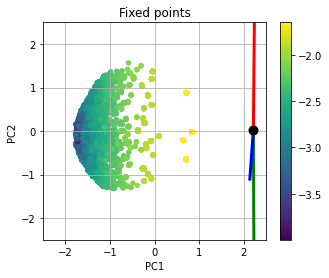

In [ ]:
# 2D Visualization of the approximate fixed points

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['g', 'b', 'r', 'y', 'orange', 'm', 'cyan', 'brown']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '.', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

plot_coords = 2.5
if plot_coords != None:
  plt.xlim(-plot_coords, plot_coords)
  plt.ylim(-plot_coords, plot_coords)

In [292]:
A = np.random.normal(size=(3,3))
eigval, eigvec = np.linalg.eig(A)
print('Original matrix:', A)
print('Eig decomp recovery', np.matmul(np.matmul(eigvec, np.diag(eigval)), np.linalg.inv(eigvec)))
print('First right eig vec:', eigvec[:,0])
print('First right eig vec mag:', np.linalg.norm(eigvec[:,0]))
print('First left eig vec:', np.linalg.inv(eigvec)[0,:])
print('First left eig vec mag:', np.linalg.norm(np.linalg.inv(eigvec)[0,:]))
print('Dot product:', np.dot(np.linalg.inv(eigvec)[0,:], eigvec[:,2]))

Original matrix: [[-1.26261933 -0.86692405 -0.62312327]
 [ 0.86418853 -1.17975876  0.22637254]
 [-0.71642736 -2.45859315  1.46109615]]
Eig decomp recovery [[-1.26261933+3.01873568e-18j -0.86692405-8.64846920e-17j
  -0.62312327-4.53645655e-18j]
 [ 0.86418853+9.06152998e-18j -1.17975876+8.85804250e-17j
   0.22637254-5.06815240e-18j]
 [-0.71642736+3.31801898e-17j -2.45859315+1.73967364e-17j
   1.46109615-5.74872104e-18j]]
First right eig vec: [-0.21691255+0.j  0.01210021+0.j  0.97611604+0.j]
First right eig vec mag: 1.0
First left eig vec: [-0.44388748+0.j -0.69052377+0.j  0.93438759+0.j]
First left eig vec mag: 1.2437601627349248
Dot product: (-2.7755575615628914e-17+5.551115123125783e-17j)


In [ ]:
print(eigvec)

[[-0.29732178+0.j          0.942862  +0.j          0.942862  -0.j        ]
 [ 0.6349273 +0.j          0.18884809-0.09753085j  0.18884809+0.09753085j]
 [-0.71306878+0.j         -0.24731981-0.06832491j -0.24731981+0.06832491j]]
